In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.realpath("")))

In [2]:
from os.path import join

from gensim.models import KeyedVectors
import fasttext as ft
import pandas as pd
import numpy as np
import umap
import umap.plot
import hdbscan
from sklearn.cluster import DBSCAN

import utilities

pd.set_option('display.max_rows', 500)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
lexicon = utilities.get_arabic_lexicon_data("..")

In [4]:
glf_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "glf.vec"))
egy_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "egy.vec"))
irq_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "irq.vec"))
nor_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "nor.vec"))
lev_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "lev.vec"))

In [5]:
def generate_emotion_lexicon(embedding, emotion, min_cluster_size, num_words_to_generate=100, verbose=False, save=False, embedding_name=None):
    if save:
        assert embedding_name is not None, "embedding_name must not be None when trying to save" 
    
    lexicon = utilities.get_arabic_lexicon_data("..")
    def get(embedding, val, default=None):
        try:
            return embedding[val]
        except KeyError:
            return default

    emotions = list(lexicon.keys())
    if verbose:
        print(f"Emotions in lexicon {emotions}")
    assert emotion in lexicon, f"The emotion {emotion} is not in the Lexicon"

    vecs_non_filtered = list(map(lambda wrd: get(embedding, wrd, default=None), lexicon[emotion]))
    if verbose:
        print(f"Number of words considered {sum(1 for vec in vecs_non_filtered if vec is not None)}/{len(vecs_non_filtered)}")
    vecs = list(filter(lambda x: x is not None, vecs_non_filtered))
    centroid = np.mean(vecs, axis=0)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(vecs)

    if verbose:
        print(cluster_labels)
    cluster_to_words = {}
    for focus_cluster in np.unique(cluster_labels):
        clustered_vecs = [vec for cluster, vec in zip(cluster_labels, vecs) if cluster == focus_cluster]
        clustered_centroid = np.median(clustered_vecs, axis=0)
        cluster_to_words[focus_cluster] = list(zip(*embedding.similar_by_vector(clustered_centroid, num_words_to_generate)))[0]

    if verbose:
        mapper = umap.UMAP().fit(vecs)
        umap.plot.points(mapper, labels=cluster_labels)
    df = pd.DataFrame(cluster_to_words)
    style = df.style.applymap(lambda x: "background-color: rgba(20, 20, 20, 1)" if x in lexicon[emotion] else "")
    if save:
        df.to_csv(f"emotion_lexicon/{embedding_name}_{emotion}_minclustersize={min_cluster_size}.csv")
    return style

## Problems

### Problem with using all words in generating similar words
### Solution: cluster the vector representation of words

In [6]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="anger", min_cluster_size=100, num_words_to_generate=500)
df.data.iloc[:20]

,-1
0,لطخ
1,خبائث
2,طغا
3,بذيء
4,وماخفى
5,ذآ
6,اظمى
7,تلذذ
8,أشمط
9,جحود


### Problem with centroid idea
### Solution(?): Maybe decrease the min_cluster_size?
![img](https://www.researchgate.net/profile/Fotios-Katsilieris-2/publication/239926467/figure/fig4/AS:669426328301595@1536615082633/An-example-of-the-difference-between-a-convex-and-a-non-convex-region.ppm)


# Notes

### finding the centroid with the mean seems to give worse performance than finding it with the median. Probably since the mean is swayed by outlier vectors 

# Glf

Emotions in lexicon ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
Number of words considered 540/1092
[-1 -1 10  5 10 -1 -1 -1 -1 -1 12 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  5 10
 10 10 10  5 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 11
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 10
 10 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1  5  5 11 -1 10  5 -1 -1 -1 -1 -1 11
  5  5 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 12 12 -1 12 12 12  5 -1
 12 -1 -1 12 11 -1 -1 12 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 11 11 -1
 -1 11 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 11 11 -1  8 -1 11 11 -1 -1 11 11 11
  5  5 11  5  2  8  5 12 -1 11 -1 -1 -1 -1  8  8 -1 -1 -1 -1 -1 -1 -1 -1
  5 -1 -1 -1  8 -1 -1 -1 -1 -1 -1  5  5  2  7  7 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  5  0  2 -1 -1 -1 -1 -1  0  0  6 -1  6  6  0  6  6
  6  6 -1  2  2 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1  7  2
 -1 -1 -1  3 -1  0  6 -1  2  3  2 -1 -1 -1 -1 -1 -1  3  3  9 -1 -1 -1 -1
 -1 -1  1

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12
0,لطخ,كره,طمع,حقد,حسد,حاقد,غضب,كراهية,عداء,ضايق,حسود,سخط,غاضب,منزعج
1,خبائث,اكره,مطمع,تحقد,نحسد,حاسد,ضب,كراهي,أعداء,يضايق,محسود,غفا,يقهرك,منزه
2,ذآ,أكره,مكتوف,هالحقد,احسد,ناقد,خبائث,كراهيه,اعداء,تضايق,جحود,أحصى,طغا,منزوع
3,طغا,مكره,طم,كراهية,حاسد,اقد,أيقظ,احتقار,فداء,يتضايق,معصم,دعآء,شكى,منغص
4,بذيء,طفره,طماط,حقر,لاتحسد,حسود,غضبان,وحشية,آداء,اتضايق,لعنبو,أزاغ,ذآ,أزعج
5,ى,مايكره,مطموعي,حقارة,يحسدك,كائد,استيقظ,إذلال,عداوة,متضايق,لطخ,يؤلمك,بشوش,منبطح
6,أشمط,هالفكره,مرقا,حاقد,حسود,لطخ,حينئذ,ديكتاتور,عداو,مضايق,أسود,بخشيتك,اشهقك,انزعج
7,وماخفى,حسره,طمس,حقاره,فسد,طغى,يقظة,كرامه,إهداء,تضايقني,يعزك,محزون,يتشمت,يأخي
8,اظمى,بزوره,أطوف,يقهرني,حسوف,جحود,أذنب,طائفة,أعتداء,طايق,جاعو,نقمة,أغبى,ذائقة
9,جرثوم,كرهتني,غنا,كراهيه,حسره,محصن,معصم,استنكار,أبرياء,رايق,تلذذ,مبتلى,بذمتكم,لائق


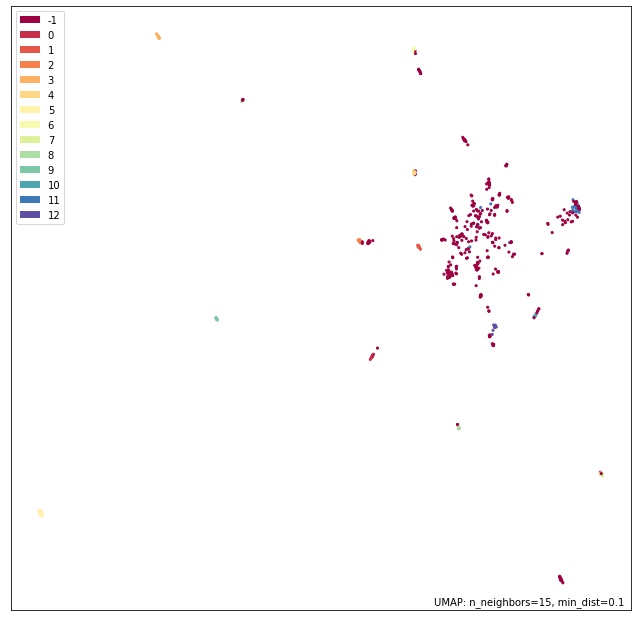

In [7]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="anger", min_cluster_size=8, num_words_to_generate=100, verbose=True)
df

In [16]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="joy", min_cluster_size=7, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,لؤي,سعادة,حب,ود,رضى,سعيد,فرح,رحيم,فتن,خير,مرح,ولع,شجع,عشق,قنع,عطف,سعد,اسعد,حنون,مفرح,انتصر,تعاطف,مسرور,استحسان,تلذذ,بهجة
1,ى,سعاد,آحب,ودود,ارضى,سعيده,فرحة,يارحيم,فتنة,خيررر,يمرح,أولع,مشجع,عشقي,اقنع,ألطف,آسعد,آسعد,عنون,يفرحك,انتصار,تعاطى,سرور,استحضر,هتاف,مهجة
2,كخ,ياسعادة,حبب,حود,أرضى,عيد,افرح,رحمن,تفتن,خيرر,مرحب,هلع,أشجع,نعشق,أقنع,لطف,مسعد,اسعدني,نون,فرح,منتصر,تعاطي,مسروق,استحقر,لطخ,أنعش
3,منغص,سعاده,حبحب,قود,رضاء,أضحى,مفرح,جحيم,فتات,خيرت,مرحبآ,مولع,اشجع,أناعشق,تقنع,أيقظ,ياسعد,أسعد,يخرفنون,افرح,أنتصرتم,متعاطف,مسعري,استحل,هتلر,لهفة
4,كلثمي,إسعاد,آلحب,ورود,رضع,وعيد,أفرح,دحيم,عروبه,بلخير,سرح,قلع,برتغال,اعشق,مقنع,ذائقة,نسعد,ياسعد,كانون,مفر,هزيمة,عاطف,مسر,استح,ذآ,لهف
5,أشمط,سعآد,ينحب,أود,بقدرتك,أسعدتنا,بشوفتك,يارحمن,ثأر,خيير,مرحلة,عع,ألاهلي,اشق,مقتنع,عطش,أسعد,اسعدتني,مكنون,يبشرك,إنتصار,تعاسة,بخور,استحسن,هتف,لحى
6,هتلر,اسعدني,نحب,هود,زنة,نشكرك,يفرحك,فارحمه,فتق,خيرة,مرؤوس,الع,أدمج,عشى,اقتنع,أولائك,سعدون,مسعد,يصارخون,أفرح,انتكاس,تعاند,غفور,إحسان,حمقى,أيقظ
7,وثائقي,أستودعتك,اتحب,ودى,امتلى,بمشاركتك,يفرحني,رؤوف,سفور,خييير,مرحل,اتولع,تشجيع,أعشقك,أقتنعت,يؤلمك,اسعد,نسعد,تتمنون,متألق,نهضه,تعايش,مسعور,استتر,طغا,بهآ
8,يشعرك,أحزن,حبش,مطرود,بخشيتك,أعيد,فبشرني,رحماك,لامعتدين,آخير,مرقع,تعآل,منافس,عاشق,يئس,حنكة,سعدي,أسعدتني,مغبون,خيررر,أنصر,تعافى,مسعا,استنقاص,جحود,يزهر
9,شكسبير,غادة,حبا,صمود,لنآ,سعي,أرح,ياأرحم,طائفي,أجزى,أشمط,تتدفى,دفجن,اعشقك,نع,عاطف,أسعدتنا,أسعدتنا,شون,أثاب,نصرة,متعاطي,موفور,احسان,بذيء,يقظة


Emotions in lexicon ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
Number of words considered 110/231
[-1  8 -1  4  4  5  0  7  7  3 -1  1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  8  2
  5 -1 -1 -1  6  0 -1 -1  3  8  4  8  2 -1  2 -1 -1 -1  5  0 -1  0  6 -1
  6 -1  5  7 -1  3 -1  8 -1  3  6  4  1  2  8  4  1  2  8  2  8  4  1  2
  8  4  1  2  8 -1 -1 -1  5  6 -1  7 -1  0 -1  7  7 -1 -1  0 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1]


,-1,0,1,2,3,4,5,6,7,8
0,لطخ,كريه,ثار,سقم,قذر,قرف,مقرف,مقيت,بغيض,سئم
1,يلعنكم,بطاريه,كثار,اشفي,مستنقع,يقرف,يقرف,مقيته,بغيظين,ائم
2,إنحطاط,اييه,غار,أشفي,ليبراليه,مقرف,نكرف,مقتول,بغض,لائم
3,اظمى,يه,تغار,سق,اقذر,قرد,قرف,مق,بغي,متشائم
4,اضحوك,ايه,اثار,إرحم,بذر,قرفان,مقزز,مقنن,غيض,مبتكر
5,رمسيس,بريه,حصار,شفاء,تهجير,نكرف,مقص,مقيد,لطخ,فصاحة
6,ثأر,بورتريه,استثار,يؤنس,ليبرالي,قرصان,كخ,مقييم,بغل,هائم
7,بؤرة,يايه,مزمار,مضجع,مقزز,قرع,جعبة,مقبوض,ولاضمير,تلذذ
8,طاغوت,امبيه,أغار,غمر,خونه,اففففف,فشخ,مقيم,بغيبتك,ملائم
9,نكح,ويه,يغار,انهك,اصطف,فشخ,قذارة,مقيآس,يعزك,ارتقاء


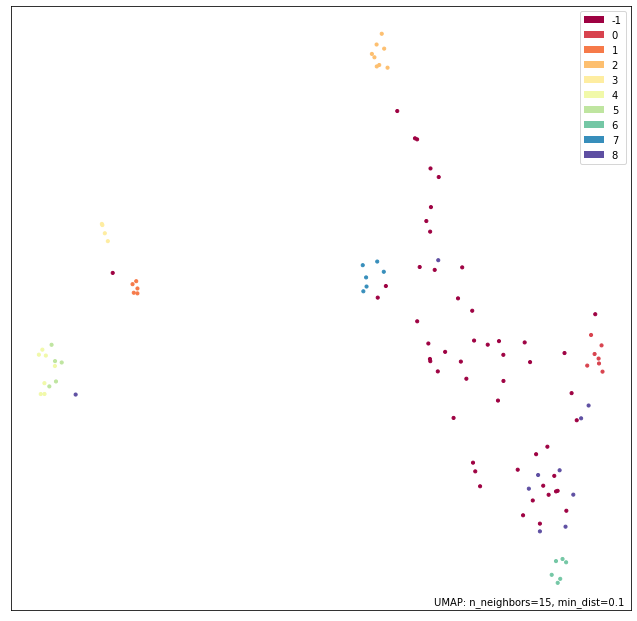

In [9]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="disgust", min_cluster_size=3, num_words_to_generate=100, verbose=True)
df

# Egy

In [10]:
df = generate_emotion_lexicon(embedding=egy_embedding, emotion="joy", min_cluster_size=13, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5
0,آ,سعيد,سعادة,فرح,مرح,نشوة,بهجة
1,لؤلؤ,سعيده,ياسعادة,فرحى,مرحبآ,نشء,بهجه
2,ئ,ياسعيد,سعادتى,إفرح,مرحل,نشوان,بهجت
3,فؤش,وعيد,سعاد,مفرح,مرحبي,ذروة,بهآ
4,بآ,سعيود,سعاده,هفرح,مرحب,نشووف,لهجة
5,ثح,اعيد,عادة,أفرح,مرحله,نشو,ضجة
6,ܟ,سعي,سعا,فرحة,مرحاض,نزعة,كاظم
7,هظا,موعيد,سعف,فرحني,مرحش,ندوة,بهت
8,فينقذك,سعف,اسعاد,فرحتنى,مرحوش,نزوة,موسيقار
9,يرزوقك,عيد,معطر,هيفرح,مرحلة,إخس,تسديدة


In [19]:
df = generate_emotion_lexicon(embedding=egy_embedding, emotion="fear", min_cluster_size=5, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5,6,7,8,9,10
0,ثح,جبان,خاف,خوف,بشع,مرعب,رعب,مخيف,قلق,متردد,فزع,خجول
1,بآ,ياجبان,هخاف,نخوف,بشعه,رعب,يرعب,مخيس,اقلق,متردش,حزقيال,عجول
2,فينقذك,إبان,خافت,تخوف,أبشع,يرعب,ترعب,خيف,أقلق,متردي,آر,جول
3,لؤلؤ,دبان,خافي,خوفى,ابشع,ترعب,مرعب,سخيف,مقلق,متركزش,يقاتلونكم,مذلول
4,ܟ,بان,سخاف,خوفو,بشاعه,مرع,رع,أرشيف,قلقاس,متردوش,زعزع,يطوول
5,مقذذ,ربان,حيخاف,هيصلحلك,عالاطفال,مرعى,اصعب,عنيف,قلقان,اتردد,لآينتمون,متسبتنيش
6,آ,جباي,خافو,خوض,تخفف,مرآه,رعش,إسحاق,هيصلحلك,تردد,نصمد,نطول
7,ᴉ,قربان,أخاف,خوج,اتسعرت,مخيف,رعية,مخير,تفلق,مترف,لؤلؤ,رجول
8,زىى,خائف,هنخاف,خوذ,ااطفال,مرجيح,مخيف,ظريف,هلق,مترحش,نقتدى,هطول
9,غشاو,لبان,يتخاف,خوت,اطفال,مرهق,سعب,تصقيف,شلق,مترديش,بءس,يركبولها


In [12]:
df = generate_emotion_lexicon(embedding=egy_embedding, emotion="anger", min_cluster_size=9, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5,6,7,8,9
0,بآ,كره,حقد,حسد,طمع,حاقد,غضب,عداء,كراهية,بغض,غاضب
1,ئ,عكره,نحقد,نحسد,طمعان,حاقضين,غضبة,أعداء,كراهي,بغيض,غاض
2,بزيئ,أكره,تحقد,احسد,مطمع,أنف,أغضب,اعداء,كراهيه,بغ,غا
3,ثح,اكره,حاقد,تتحسد,جشع,حاسد,غضبان,يااعداء,ناهية,نغض,غامض
4,آ,تزكره,حقكك,حسل,يبأ,انف,عضب,فداء,إكراه,يقاتلونكم,غاضني
5,ᴉ,عفكره,حاقضين,حسود,يريكم,حاق,مقت,اخاء,ماهية,بغي,لاتغضب
6,لؤلؤ,هكرهك,كراهية,حاسد,ابجار,اثرالعراق,قضب,غداء,تثنية,بغا,يؤخذ
7,رثا,كرهتنا,حقار,ماشاءلله,طمأن,حقد,لاتغضب,عمداء,وصية,زعزعة,غاظ
8,زىى,بكره,كراهي,حسره,ماجمع,كائد,ضب,داء,لآينتمون,أجج,غاو
9,بءس,مذكره,وغل,حسر,انتفاع,غظ,أرفع,عداو,نبذ,غشاو,عضب


# Lev

In [20]:
df = generate_emotion_lexicon(embedding=lev_embedding, emotion="disgust", min_cluster_size=5, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5
0,ى,كريه,قرف,سقم,مقيت,سئم,بغيض
1,ىا,فكريه,يقرف,يعافينا,تفتيت,لائم,بغي
2,نلطم,آيه,اقرف,أشفي,مقيط,ائم,بغض
3,سذج,بريه,يقرفكم,اشفي,تثبيت,شؤم,بغا
4,لئن,سخريه,تقرف,ويغفرله,مقتبس,؛,بغية
5,’,قريه,قرفتونا,اامين,بذخ,سذج,آبتسم
6,سئ,شوفريه,قرفناكم,آمييين,سئ,يتلائم,سذج
7,يسخطك,حريه,قرفتنا,يشافيه,مغناطيسي,وغد,غيض
8,طغاه,قطريه,مقرف,يشافيك,نهضة,تشرذم,خسئتم
9,اوساخ,روايه,يقرفك,ويصبراهلهم,مهاترات,ملائم,أنذر


# IRQ

In [14]:
df = generate_emotion_lexicon(embedding=irq_embedding, emotion="sadness", min_cluster_size=9, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5,6,7,8
0,Ꭿ,ندم,حزين,حزن,نادم,محزن,بائس,بؤس,مفجوع,كئيب
1,ى,شيءندم,كتوم,محزن,نادية,أحزن,بائع,مأزق,خشوع,نحيب
2,يؤم,اندم,كآبة,آلحزن,بإس,حزن,ذريع,ذراع,ى,تأنيب
3,غمز,عليهأجاب,تخزين,احزن,آدم,احزن,بائد,طغو,مزدحم,عصيب
4,ذ,ثمانون,خلوني,أحزن,ادم,آلحزن,طغا,يدعونك,مفخخه,تطيب
5,آ,أتبرع,دايم,حز,اغفو,مآآبكي,إجحاف,خنق,جوع,مغيب
6,هففف,روائي,انحب,خزن,غفا,لاتحزن,تثقيف,بوركتم,هففف,لاأعرفك
7,أقتنعت,ندمان,متوحد,سومرست,نادى,محا,حذو,آ,مفضله,تسيب
8,اصدقائك,تعيس,منهك,خذلان,اندم,بفرآقك,إقصاء,وغد,خضوع,أفترقنا
9,},يؤآزر,حز,آلمشآعر,لكأحلم,محبط,00,نزق,مفجر,أثرثر


In [15]:
df = generate_emotion_lexicon(embedding=irq_embedding, emotion="surprise", min_cluster_size=5, num_words_to_generate=100)
df

,-1,0,1,2,3
0,هففف,عجب,مفاجئ,مذهل,ذهل
1,Ꭿ,اعجب,دهشة,ذهل,ذهآبك
2,بصفحتك,تعجب,Ꭿ,أفعآله,أذهل
3,يؤم,تنعجب,آ,ردآ,ركآم
4,ضفادع,شعجب,مفجوع,أذهل,آهل
5,ءء,معجب,تلألأ,أمآرس,مذهل
6,ييسونغ,أعجب,أثرثر,إشتياق,منفى
7,يفهمونها,عج,ى,شآحا,ذهن
8,فئ,فواعجبا,غمز,ترنم,أيقظ
9,مغثوث,جب,هلوسة,اصدقائك,وأوسطهآ
